In [163]:
import pandas as pd
import xgboost as xgb
from IPython.display import display







In [164]:
data=pd.read_csv(r'C:\Users\HP\Desktop\final.csv')
display(data.head(3))


,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,HS,AS,...,BbAvq,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,Barcelona,Real Madrid,5,1,H,2,0,H,13,15,...,2.46,17.00,-0.25,1.75,1.72,2.28,2.20,2.06,3.72,3.69
1,Real Madrid,Barcelona,0,1,A,0,1,A,17,10,...,2.64,18.00,0.25,1.78,1.74,2.20,2.15,2.65,3.80,2.64
2,Real Madrid,Barcelona,0,3,A,0,0,D,14,18,...,1.42,1.38,3.10,2.98,17.00,-0.25,1.85,1.83,2.09,2.05


In [165]:
#exploring data
n_matches=data.shape[0]
n_features=data.shape[1] - 1
n_homewins=len(data[data.FTR == 'H'])
win_rate= (float(n_homewins) / (n_matches)) *100 
print ("Total number of matches: {}".format(n_matches))
print ("Number of features: {}".format(n_features))
print ("Total homewins :{}".format(n_homewins))
print ("The home win rate is: {:.2f} %".format(win_rate))



Total number of matches: 22
Number of features: 58
Total homewins :8
The home win rate is: 36.36 %


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000021B7BE30C88>,
      dtype=object)

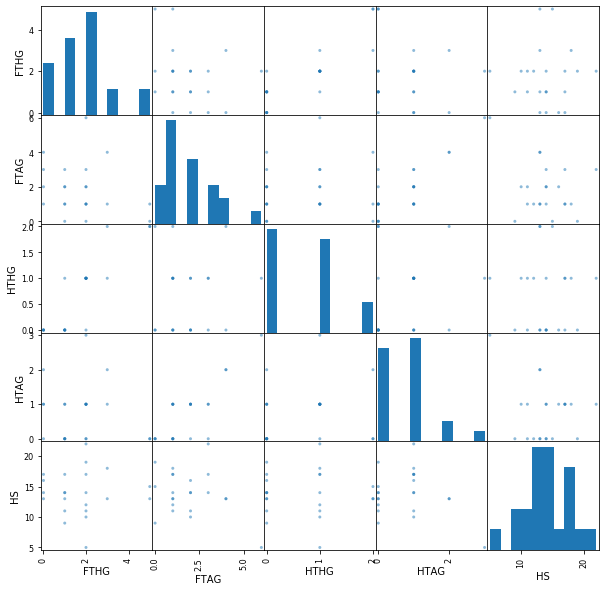

In [166]:
from pandas.plotting import scatter_matrix
scatter_matrix(data[['FTHG','FTAG','HTHG','HTAG','HS']], figsize=(10,10))

In [167]:
#seperating full time result with other features
X_all = data.drop(['FTR'],1)
y_all = data['FTR']
from sklearn.preprocessing import scale
cols = [['FTHG','FTAG','FTAG','HS','HTAG']]
for col in cols:
    X_all[col] = scale(X_all[col])

In [168]:

#converting all features into same (integer)type
def preprocess_features(X):
    output = pd.DataFrame(index = X.index)

    for col, col_data in X.iteritems():

        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix = col)
                    
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print ("Processed feature columns {} total features):\n{}".format(len(X_all.columns), list(X_all.columns)))

Processed feature columns 62 total features):
['HomeTeam_Barcelona', 'HomeTeam_Real Madrid', 'AwayTeam_Barcelona', 'AwayTeam_Real Madrid', 'FTHG', 'FTAG', 'HTHG', 'HTAG', 'HTR_A', 'HTR_D', 'HTR_H', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD', 'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx', 'BbAv', 'BbMxq', 'BbAvq', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA', 'BbAvAHA', 'PSCH', 'PSCD', 'PSCA']


In [144]:

print ("\nFeature values:")
display(X_all.head())


Feature values:


,HomeTeam_Barcelona,HomeTeam_Real Madrid,AwayTeam_Barcelona,AwayTeam_Real Madrid,FTHG,FTAG,HTHG,HTAG,HTR_A,HTR_D,...,BbAvq,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,PSCH,PSCD,PSCA
0,1,0,0,1,2.416162,-0.593460,2,-0.973417,0,0,...,2.46,17.00,-0.25,1.75,1.72,2.28,2.20,2.06,3.72,3.69
1,0,1,1,0,-1.275197,-0.593460,0,0.286299,1,0,...,2.64,18.00,0.25,1.78,1.74,2.20,2.15,2.65,3.80,2.64
2,0,1,1,0,-1.275197,0.780869,0,-0.973417,0,1,...,1.42,1.38,3.10,2.98,17.00,-0.25,1.85,1.83,2.09,2.05
3,1,0,0,1,0.201347,0.093704,1,0.286299,0,1,...,1.36,1.33,3.40,3.22,20.00,-0.75,1.87,1.82,2.11,2.04
4,1,0,0,1,-0.536925,-0.593460,0,-0.973417,0,1,...,1.45,1.40,3.00,2.86,26.00,-1.00,2.50,2.41,1.62,1.59


In [169]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, 
                                                    test_size = 0.2,
                                                    random_state =0)

In [170]:

from time import time 

from sklearn.metrics import f1_score

def train_classifier(clf, X_train, y_train):
    
    

    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
   
    print ("Trained model in {:.4f} seconds".format(end - start))

    
def predict_labels(clf, features, target):
    
    
  
    start = time()
    y_pred = clf.predict(features)
    
    end = time()
    
    print ("Made predictions in {:.4f} seconds.".format(end - start))
    
    return f1_score(target, y_pred, average='micro'), sum(target == y_pred) / float(len(y_pred))


def train_predict(clf, X_train, y_train, X_test, y_test):
    
    
    print ("Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train)))
    

    train_classifier(clf, X_train, y_train)
    
    f1, acc = predict_labels(clf, X_train, y_train)
    print (f1, acc)
    print ("F1 score and accuracy score for training set: {:.4f} , {:.4f}.".format(f1 , acc))
   
    f1, acc = predict_labels(clf, X_test, y_test)
    print ("F1 score and accuracy score for test set: {:.4f} , {:.4f}.".format(f1 , acc))

In [171]:
clf_X = xgb.XGBClassifier(seed = 82)

train_predict(clf_X , X_train , y_train , X_test , y_test)
print ('')

Training a XGBClassifier using a training set size of 17. . .
Trained model in 0.0653 seconds
Made predictions in 0.0025 seconds.
1.0 1.0
F1 score and accuracy score for training set: 1.0000 , 1.0000.
Made predictions in 0.0012 seconds.
F1 score and accuracy score for test set: 0.6000 , 0.6000.

